# **Porto Seguro’s Safe Driver Prediction**

## **Predict if a driver will file an insurance claim next year.**
https://www.kaggle.com/competitions/porto-seguro-safe-driver-prediction

## **Mission : 운전자가 보험을 청구할 확률 예측**

### **평가지표: 정규화된 지니계수**

#### $$ Normalized \ Gini \ coefficient = \frac{Gini \ coefficient \ for \ predicted \ value}{Gini \ coefficient \ when \ the \ prediction \ is \ perfect}  $$

### **문제유형: 이진분류**

#### **사용 모델 : XGBoost LightGBM Ensemble Model**

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.utils.validation")

from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

!pip3 install xgboost
!pip3 install lightgbm
!pip install catboost

import xgboost as xgb
import lightgbm as lgb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PowerTransformer

!pip install optuna 
import optuna

In [2]:
train = pd.read_csv(r"C:\Users\degas\Desktop\porto-seguro-safe-driver-prediction\train.csv")
test = pd.read_csv(r"C:\Users\degas\Desktop\porto-seguro-safe-driver-prediction\test.csv")
submission = pd.read_csv(r'C:\Users\degas\Desktop\porto-seguro-safe-driver-prediction\sample_submission.csv')

In [3]:
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              595212 non-null  int64  
 1   target          595212 non-null  int64  
 2   ps_ind_01       595212 non-null  int64  
 3   ps_ind_02_cat   595212 non-null  int64  
 4   ps_ind_03       595212 non-null  int64  
 5   ps_ind_04_cat   595212 non-null  int64  
 6   ps_ind_05_cat   595212 non-null  int64  
 7   ps_ind_06_bin   595212 non-null  int64  
 8   ps_ind_07_bin   595212 non-null  int64  
 9   ps_ind_08_bin   595212 non-null  int64  
 10  ps_ind_09_bin   595212 non-null  int64  
 11  ps_ind_10_bin   595212 non-null  int64  
 12  ps_ind_11_bin   595212 non-null  int64  
 13  ps_ind_12_bin   595212 non-null  int64  
 14  ps_ind_13_bin   595212 non-null  int64  
 15  ps_ind_14       595212 non-null  int64  
 16  ps_ind_15       595212 non-null  int64  
 17  ps_ind_16_

In [5]:
test.head()

,id,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,0,0,1,8,1,0,0,1,0,0,...,1,1,1,12,0,1,1,0,0,1
1,1,4,2,5,1,0,0,0,0,1,...,2,0,3,10,0,0,1,1,0,1
2,2,5,1,3,0,0,0,0,0,1,...,4,0,2,4,0,0,0,0,0,0
3,3,0,1,6,0,0,1,0,0,0,...,5,1,0,5,1,0,1,0,0,0
4,4,5,1,7,0,0,0,0,0,1,...,4,0,0,4,0,1,1,0,0,1


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 892816 entries, 0 to 892815
Data columns (total 58 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              892816 non-null  int64  
 1   ps_ind_01       892816 non-null  int64  
 2   ps_ind_02_cat   892816 non-null  int64  
 3   ps_ind_03       892816 non-null  int64  
 4   ps_ind_04_cat   892816 non-null  int64  
 5   ps_ind_05_cat   892816 non-null  int64  
 6   ps_ind_06_bin   892816 non-null  int64  
 7   ps_ind_07_bin   892816 non-null  int64  
 8   ps_ind_08_bin   892816 non-null  int64  
 9   ps_ind_09_bin   892816 non-null  int64  
 10  ps_ind_10_bin   892816 non-null  int64  
 11  ps_ind_11_bin   892816 non-null  int64  
 12  ps_ind_12_bin   892816 non-null  int64  
 13  ps_ind_13_bin   892816 non-null  int64  
 14  ps_ind_14       892816 non-null  int64  
 15  ps_ind_15       892816 non-null  int64  
 16  ps_ind_16_bin   892816 non-null  int64  
 17  ps_ind_17_

In [7]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 892816 entries, 0 to 892815
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      892816 non-null  int64  
 1   target  892816 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 13.6 MB


In [8]:
def resumetable(df):
    print(f'데이터셋 형상: {df.shape}')
    summary = pd.DataFrame(df.dtypes, columns=['데이터 타입'])
    summary = summary.reset_index()
    summary = summary.rename(columns={'index': '피처 값'})
    summary['결측값 개수'] = (df == -1).sum().values
    summary['고윳값 개수'] = df.nunique().values
    summary['첫 번째 값'] = df.loc[0].values
    summary['두 번째 값'] = df.loc[1].values
    
    return summary

summary1 = resumetable(train)
summary2 = resumetable(test)

데이터셋 형상: (595212, 59)
데이터셋 형상: (892816, 58)


In [9]:
summary1
# 결측값 -1로 존재 : 

,피처 값,데이터 타입,결측값 개수,고윳값 개수,첫 번째 값,두 번째 값
0,id,int64,0,595212,7.000000,9.000000
1,target,int64,0,2,0.000000,0.000000
2,ps_ind_01,int64,0,8,2.000000,1.000000
3,ps_ind_02_cat,int64,216,5,2.000000,1.000000
4,ps_ind_03,int64,0,12,5.000000,7.000000
5,ps_ind_04_cat,int64,83,3,1.000000,0.000000
6,ps_ind_05_cat,int64,5809,8,0.000000,0.000000
7,ps_ind_06_bin,int64,0,2,0.000000,0.000000
8,ps_ind_07_bin,int64,0,2,1.000000,0.000000
9,ps_ind_08_bin,int64,0,2,0.000000,1.000000


In [10]:
summary2

,피처 값,데이터 타입,결측값 개수,고윳값 개수,첫 번째 값,두 번째 값
0,id,int64,0,892816,0.000000,1.000000
1,ps_ind_01,int64,0,8,0.000000,4.000000
2,ps_ind_02_cat,int64,307,5,1.000000,2.000000
3,ps_ind_03,int64,0,12,8.000000,5.000000
4,ps_ind_04_cat,int64,145,3,1.000000,1.000000
5,ps_ind_05_cat,int64,8710,8,0.000000,0.000000
6,ps_ind_06_bin,int64,0,2,0.000000,0.000000
7,ps_ind_07_bin,int64,0,2,1.000000,0.000000
8,ps_ind_08_bin,int64,0,2,0.000000,0.000000
9,ps_ind_09_bin,int64,0,2,0.000000,1.000000


## **feature 알아보기**

- 01. target
    - 타겟변수, 이진 피쳐
    - type : int64

- 02. ps_ind_02_cat, ps_ind_04_cat, ps_ind_05_cat, ps_car_01_cat ~ ps_car_11_cat
    - 명목형 피쳐 (14개)
    - type : int64

- 03. ps_reg_01 ~ ps_reg_03, ps_car_12 ~ ps_car_15, ps_calc_01 ~ ps_calc_03
    - 연속형 피쳐 (10개)
    - type : float64

- 04. ps_ind_06_bin	~ ps_ind_18_bin, ps_calc_15_bin	~ ps_calc_20_bin
    - 이진 피쳐 (17개)
    -  type : int64

- 05. ps_ind_01 ~ ps_ind_15, ps_car_11, ps_calc_04 ~ ps_calc_14
    - 순서형 피쳐 (16개)
    - int64

In [11]:
# 이진 피쳐 + 타겟 피쳐
bin_cols = ['target', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin', 'ps_ind_09_bin',
            'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_16_bin',
            'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin',
            'ps_calc_18_bin', 'ps_calc_19_bin', 'ps_calc_20_bin']

In [12]:
# 명목형 피쳐
cat_cols = ['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat', 'ps_car_02_cat',
            'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat',
            'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat']

In [13]:
# 순서형 피쳐
ord_cols = ['ps_ind_01', 'ps_ind_03', 'ps_ind_14', 'ps_ind_15', 'ps_car_11', 'ps_calc_04',
            'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10',
            'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14']

In [14]:
# 연속형 피쳐
con_cols = ['ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_12', 'ps_car_13', 'ps_car_14',
            'ps_car_15', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03']   

## **EDA**

target
0    573518
1     21694
Name: count, dtype: int64

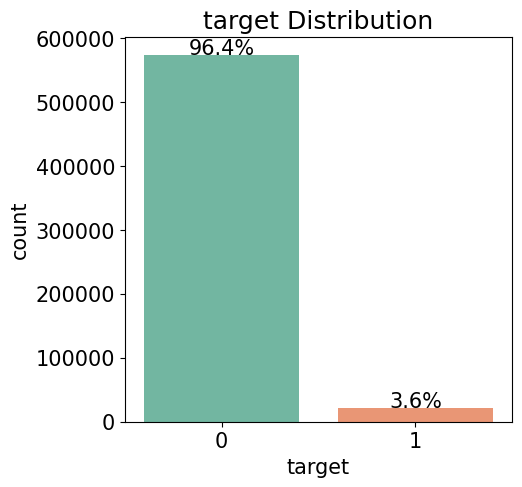

In [15]:
# 1. target 변수

def write_percent(ax, total_size):
# 도향 객체를 순회하며 막대 그래프 상단에 타깃값 비율 표시
  for patch in ax.patches:
    height = patch.get_height()       # 도형 높이(데이터 개수)
    width = patch.get_width()         # 도형 너비
    left_coord = patch.get_x()        # 도형 왼쪽 테두리의 x축 위치
    percent = height/total_size*100   # 타깃값 비율

    # (x, y) 좌표에 텍스트 입력
    ax.text(left_coord + width/2.0,      # x축 위치
            height + total_size *0.001,  # y축 위치
            '{:1.1f}%'.format(percent),  # 입력 텍스트
             ha='center')                # 가운데 정렬
mpl.rc('font', size=15)
plt.figure(figsize=(5,5))

ax = sns.countplot(x='target', data=train, palette='Set2')
write_percent(ax, len(train))
ax.set_title('target Distribution')

train['target'].value_counts()

# 타깃값이 불균형 -> 비율이 작은 타깃값 예측이 중요
# 전체 운전자 중 3.6%만 보험금을 청구

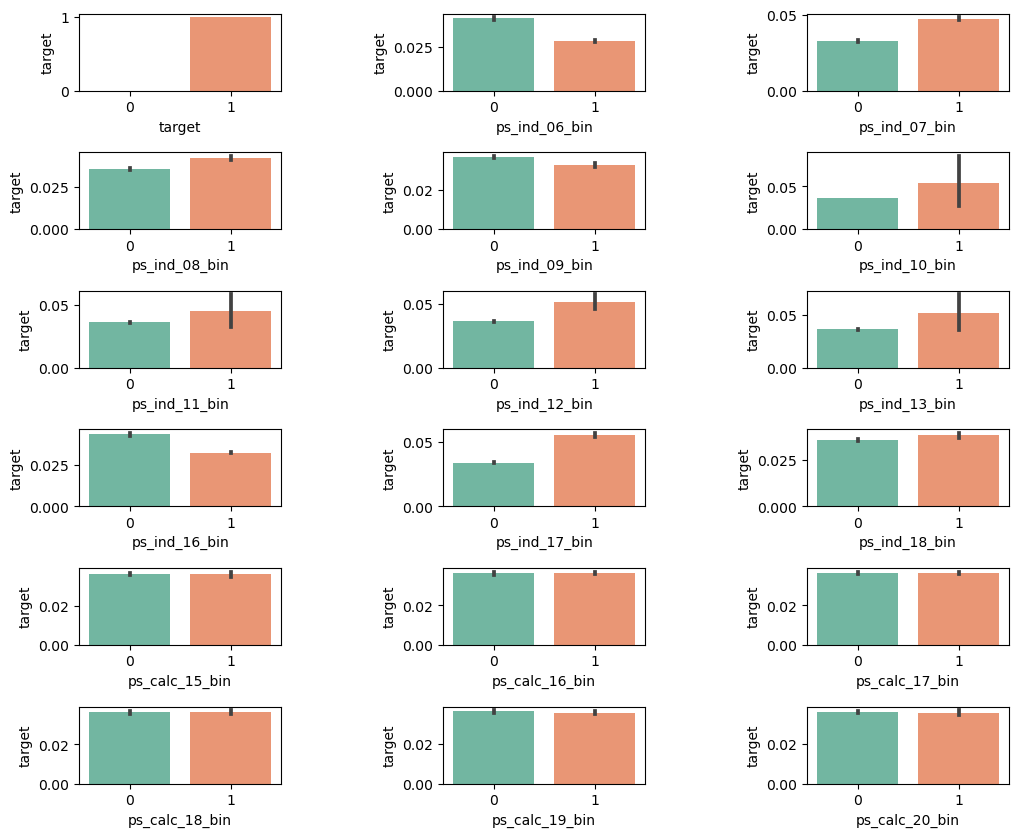

In [16]:
# 2. 이진 피쳐
# 이진 피처의 고윳값별 타깃값 비율
def plot_target_ratio_by_features(df, features, num_rows, num_cols, size=(12,8)):
  mpl.rc('font', size=10)
  plt.figure(figsize=size)
  grid = gridspec.GridSpec(num_rows, num_cols)
  plt.subplots_adjust(wspace=0.8, hspace=0.8)

  for idx, feature in enumerate(features):
    ax = plt.subplot(grid[idx])
    sns.barplot(x=feature, y='target', data=train, palette='Set2', ax=ax)

plot_target_ratio_by_features(train, bin_cols, 6, 3, size=(12,10))

# ps_ind_10_bin, ps_ind_11_bin, ps_ind_12_bin, ps_ind_13_bin
# 신뢰구간이 넓어 통계적 유효성이 떨어진다. (제거 대상)

# ps_calc_15_bin, ps_calc_16_bin, ps_calc_17_bin,
# ps_calc_18_bin, ps_calc_19_bin, ps_calc_20_bin,
# 비율 차이가 없으므로 예측력이 떨어진다. (제거 대상)

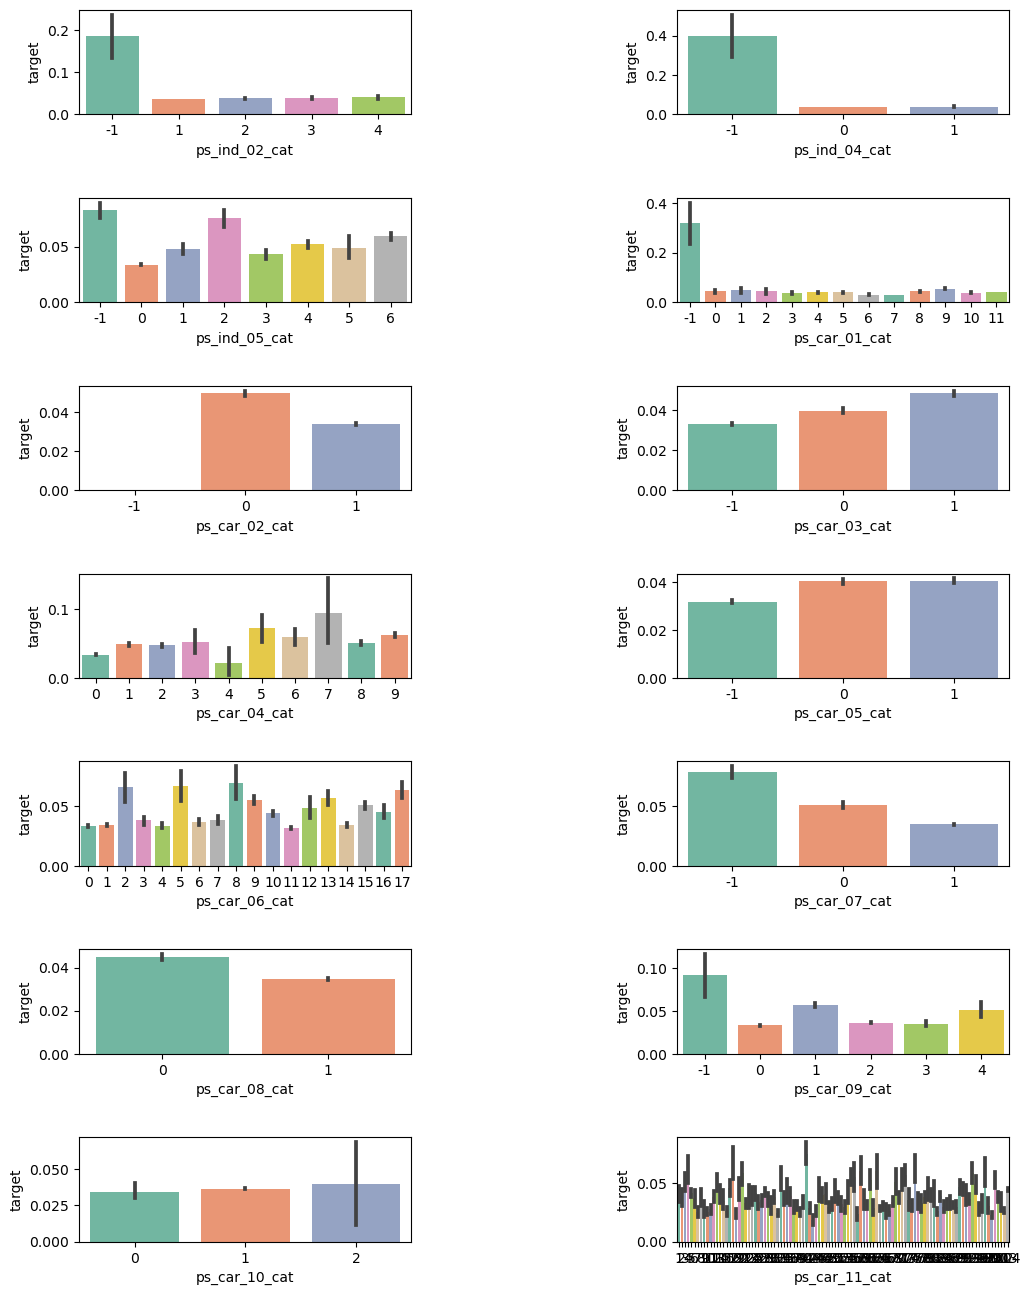

In [17]:
# 3. 명목형 피쳐
# 명목형 피처의 고윳값별 타깃값 비율
plot_target_ratio_by_features(train, cat_cols, 7, 2, size=(12,16))

# 결측값 -1로도 예측력이 있는 피쳐들 존재
# 신뢰구간이 큰 피쳐가 있지만 신뢰하한과 신뢰상한 간 차이가 크므로 사용

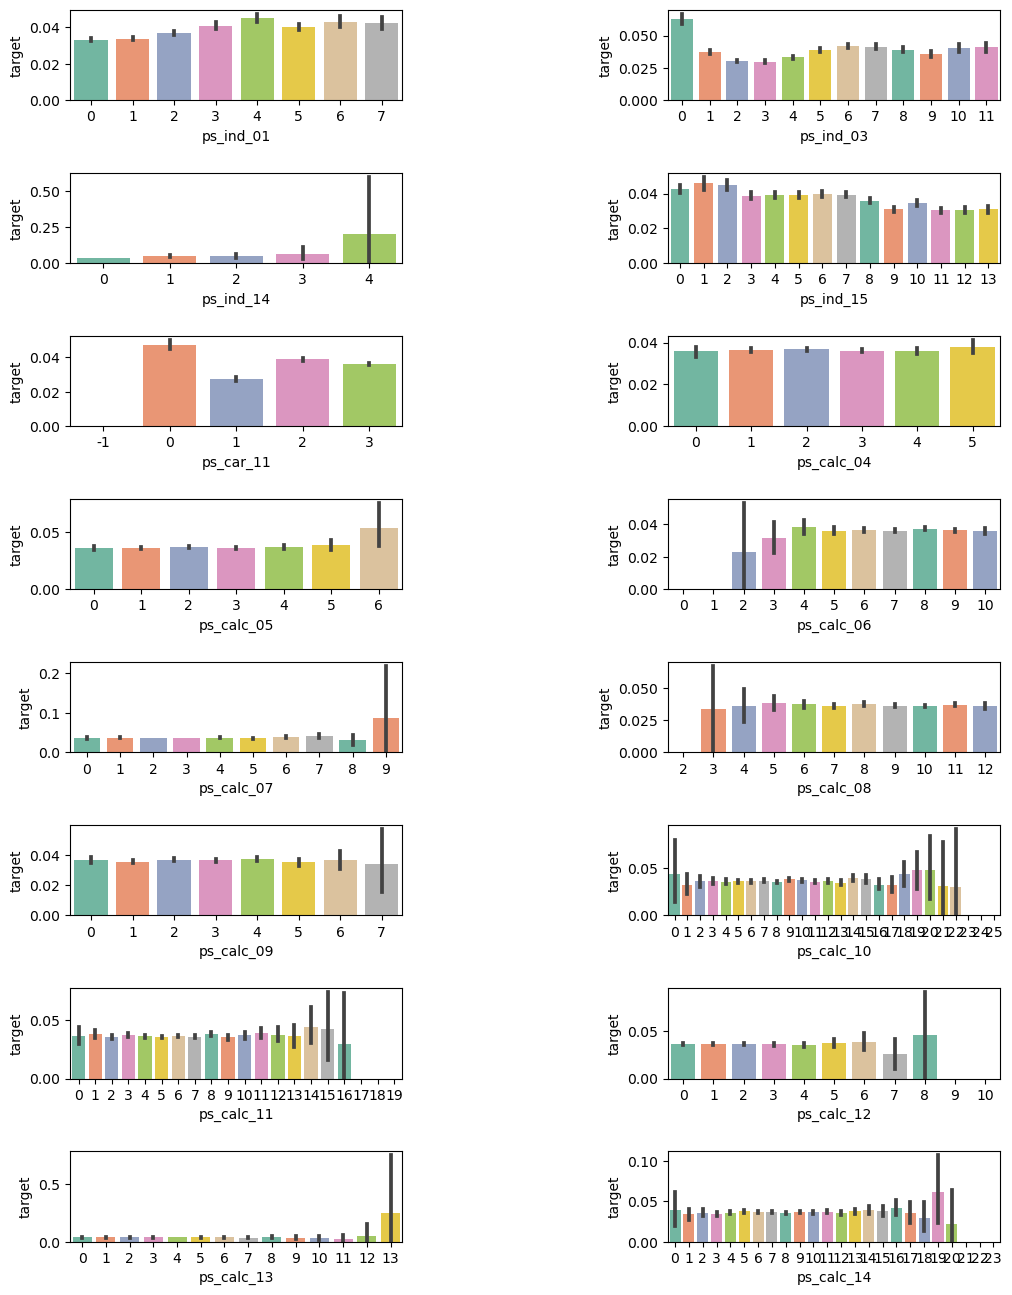

In [18]:
# 4. 순서형 피쳐
# 명목형 피처의 고윳값별 타깃값 비율
plot_target_ratio_by_features(train, ord_cols, 8, 2, size=(12,16))

# ps_ind_14 : 신뢰구간이 넓어 통계적 유효성이 떨어진다. (제거 대상)

# ps_calc_04, ps_calc_05, ps_calc_06, ps_calc_07, ps_calc_08, ps_calc_09,
# ps_calc_10, ps_calc_11, ps_calc_12, ps_calc_13, ps_calc_14
# 비율 차이가 없거나 신뢰구간이 넓어 통계적 유효성이 떨어진다. (제거 대상)

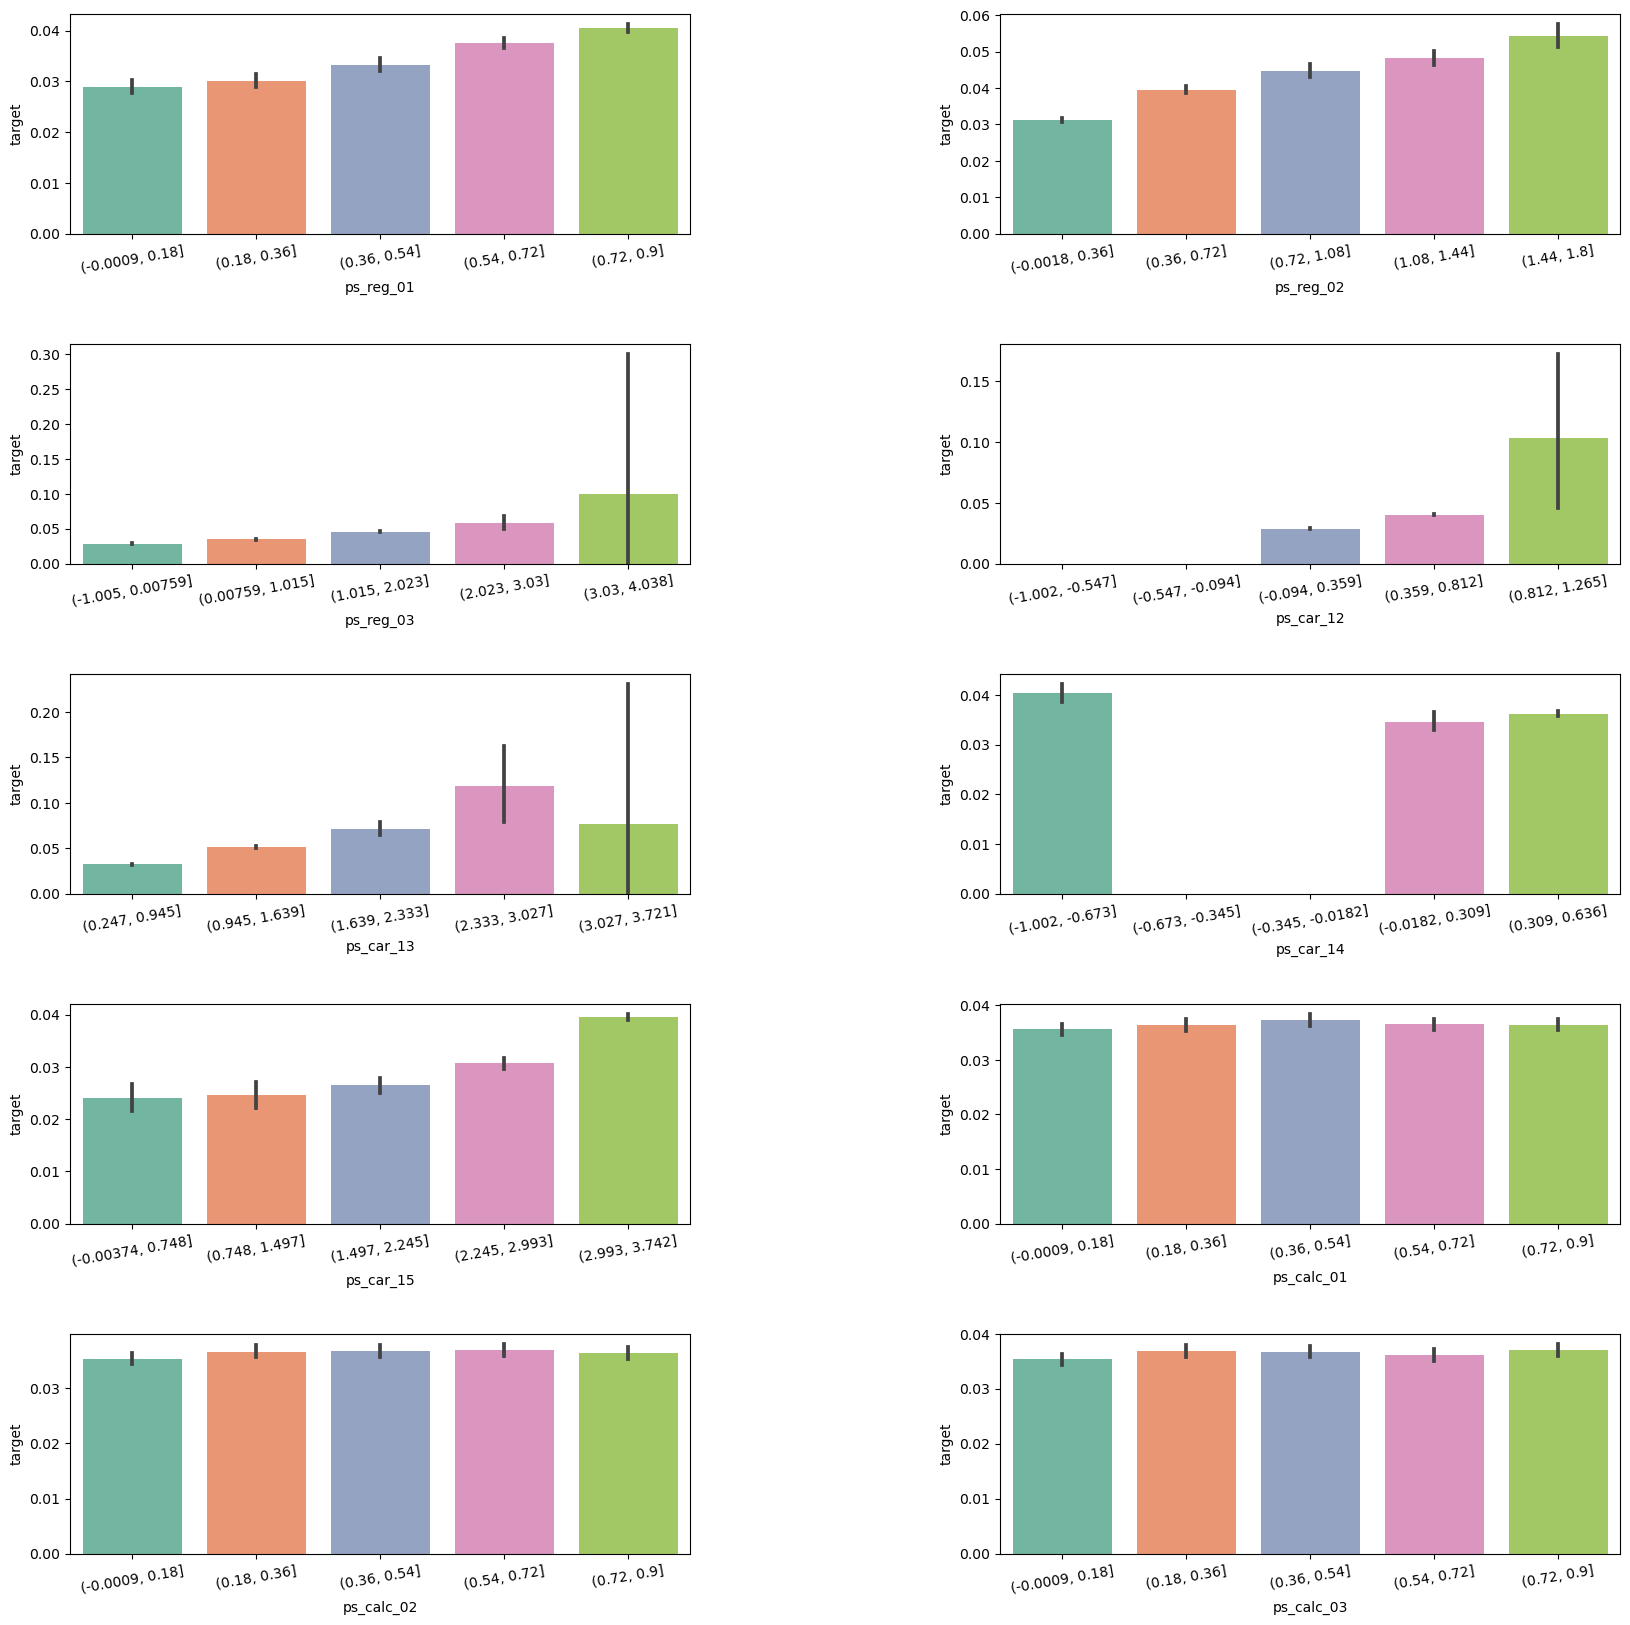

In [19]:
# 5. 연속형 피쳐
plt.figure(figsize=(20,20))
grid = gridspec.GridSpec(5,2)
plt.subplots_adjust(wspace=0.5, hspace=0.5)

for axes, con_col in enumerate(con_cols):
  train[con_col] = pd.cut(train[con_col], 5)
  ax = plt.subplot(grid[axes])
  sns.barplot(x=con_col, y='target', data=train, ax=ax, palette='Set2')
  ax.tick_params(axis='x', labelrotation=10)

# ps_calc_01, ps_calc_02, ps_calc_03
# 비율 차이가 없다. (제거 대상)

<Axes: >

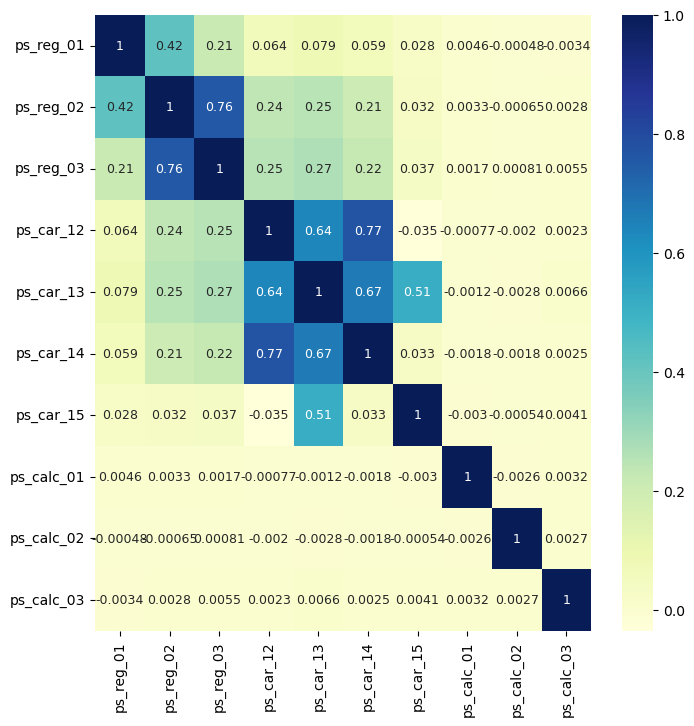

In [20]:
# heatmap 상관관계 분석
train = pd.read_csv(r"C:\Users\degas\Desktop\porto-seguro-safe-driver-prediction\train.csv")   

train = train.replace(-1, np.NaN)
train = train.dropna()
plt.figure(figsize=(8,8))
con_corr = train[con_cols].corr()
sns.heatmap(con_corr, cmap='YlGnBu', annot=True, annot_kws={"size" : 9})
# 상곤관계가 강한 피쳐 ps_car_14 제거

## **Feature 분석 정리**

- 1. 결측값은 결측값 자체로 예측력을 가지므로 제거 X


- 2. target 피쳐
    - 타깃값이 불균형 -> 비율이 작은 타깃값 예측이 중요
    - 전체 운전자 중 3.6%만 보험금을 청구


- 3. 이진형 피쳐 제거
    - 신뢰구간이 넓어 통계적 유효성 떨어짐
    - 비율 차이가 없어 예측력이 떨어짐
    - ps_ind_10_bin, ps_ind_11_bin, ps_ind_12_bin, ps_ind_13_bin
    - ps_calc_15_bin, ps_calc_16_bin, ps_calc_17_bin,
    - ps_calc_18_bin, ps_calc_19_bin, ps_calc_20_bin,


- 4. 순서형 피쳐 제거
    - 신뢰구간이 넓어 통계적 유효성 떨어짐
    - 비율 차이가 없어 예측력이 떨어짐
    - ps_ind_14, ps_calc_04, ps_calc_05, ps_calc_06, ps_calc_07, ps_calc_08,
    - ps_calc_09, ps_calc_10, ps_calc_11, ps_calc_12, ps_calc_13, ps_calc_14

- 5. 연속형 피쳐 제거
    - 비율 차이가 없어 예측력이 떨어짐
    - 상관관계가 강한 피쳐 제거
    - ps_calc_01, ps_calc_02, ps_calc_03, ps_car_14

- 6. 명목형 피쳐 제거 X
    - 신뢰구간이 넓은 피쳐가 존재하지만 신뢰하한과 신뢰상한 간 차이가 크므로 제거 X
    - 결측값 -1로도 예측력이 있는 피쳐들 존재 (제거 X)

## **Feature Engineering**

In [21]:
# 데이터를 다시 불러오기 초기화 
train = pd.read_csv(r"C:\Users\degas\Desktop\porto-seguro-safe-driver-prediction\train.csv", index_col='id')
test = pd.read_csv(r"C:\Users\degas\Desktop\porto-seguro-safe-driver-prediction\test.csv", index_col='id')
submission = pd.read_csv(r'C:\Users\degas\Desktop\porto-seguro-safe-driver-prediction\sample_submission.csv', index_col='id')


In [22]:
data = pd.concat([train, test], ignore_index=True)
data = data.drop('target', axis=1)

data_features = data.columns
data_features

Index(['ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat',
       'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin',
       'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin',
       'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15', 'ps_ind_16_bin',
       'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03',
       'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat',
       'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat',
       'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat', 'ps_car_11',
       'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15', 'ps_calc_01',
       'ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_05', 'ps_calc_06',
       'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10', 'ps_calc_11',
       'ps_calc_12', 'ps_calc_13', 'ps_calc_14', 'ps_calc_15_bin',
       'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin',
       'ps_calc_20_bin'],
      dtype='obj

In [23]:
# 명목형 피쳐 - 원-핫 인코딩
from sklearn.preprocessing import OneHotEncoder

onehotencoder = OneHotEncoder()

encoded_cat_matrix = onehotencoder.fit_transform(data[cat_cols])

In [24]:
# 파생 피쳐 추가
# 1. 한 데이터가 가진 결측값 개수를 파생 피쳐로 만든다. (-1의 개수)
data['nan_count'] = (data == -1).sum(axis=1)

remaining_features = [feature for feature in data_features
                      if ('cat' not in feature and 'calc' not in feature)]

remaining_features.append('nan_count') # 파생 피쳐 추가

# 2. 모든 ind 피쳐를 연결해 새로운 피쳐 생성
ind_features = [feature for feature in data_features if 'ind' in feature]

is_first_feature = True
for ind_feature in ind_features:
  if is_first_feature:
    data['mix_ind'] = data[ind_feature].astype(str) + '_'
    is_first_feature = False
  else:
    data['mix_ind'] = data['mix_ind'] + data[ind_feature].astype(str) +'_'

# 3. 명목형 피쳐의 고윳값별 개수를 새로운 피쳐로 추가
cat_count_features = []
for feature in cat_cols+['mix_ind']:
  val_counts_dict = data[feature].value_counts().to_dict()
  data[f'{feature}_count'] = data[feature].apply(lambda x: val_counts_dict[x])
  cat_count_features.append(f'{feature}_count')
   

In [25]:
# 필요없는 피쳐 제거
from scipy import sparse 
drop_features =['ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_14', 'ps_car_14']
# remaining_featuresm cat_count_features에서 drop_features를 제거한 데이터
remaining_data = data[remaining_features+cat_count_features].drop(drop_features, axis=1)
data = sparse.hstack([sparse.csr_matrix(remaining_data), encoded_cat_matrix], format='csr')


In [26]:
# 데이터 나누기
len_train = len(train)

X = data[:len_train]
X_test = data[len_train:]
y = train['target'].values

In [27]:
# 평가지표 계산
# 지니계수
def eval_gini(y_true, y_pred):

  assert y_true.shape == y_pred.shape # 실제값과 예측값의 크기가 같은지 확인(다르면 오류 발생)

  n_samples = y_true.shape[0] # 데이터 개수
  L_mid = np.linspace(1 / n_samples, 1, n_samples) # 대각선 값

  # 1) 예측값에 대한 지니계수
  pred_order = y_true[y_pred.argsort()] # y_pred 크기순으로 y_true 값 정렬
  L_pred = np.cumsum(pred_order) / np.sum(pred_order) # 로렌츠 곡선
  G_pred = np.sum(L_mid - L_pred) # 예측값에 대한 지니계수
 
  # 2) 예측이 완벽할 때 지니계수
  true_order = y_true[y_true.argsort()] # y_true 크기순으로 y_true 값 정렬
  L_true = np.cumsum(true_order) / np.sum(true_order) # 로렌츠 곡선
  G_true = np.sum(L_mid - L_true) # 예측이 완벽할 때 지니계수

  # 정규화된 지니계수
  return G_pred / G_true

# 모델 훈련 시 검증 파라미터에 전달하기 위한 함수
def gini(preds, dtrain):
  labels = dtrain.get_label() # 데이터셋의 타깃값 반환 / 실제 타깃값 labels와 예측 확률값 preds를 활용해 정규화 지니계수를 구한다.
  return 'gini', eval_gini(labels, preds), True # 평가 지표 이름, 평가점수, 평가 점수가 높을수록 좋은지 여부
  # 지니계수가 클록수록 모델 성능이 좋다는 의미이므로 True 고정

In [28]:
# 하이퍼파라미터 최적화
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)

# 베이지안 최적화용 데이터셋
bayes_dtrain = lgb.Dataset(X_train, y_train)
bayes_dvalid = lgb.Dataset(X_valid, y_valid)

# 하이퍼파라미터 범위 설정
# 1. 하이퍼파라미터 범위를 점점 좁히는 방법
# 2. 다른 상위권 캐글러가 설정한 하이퍼파라미터를 참고하는 방법.(지금은 이 방법 선택)

# 베이지안 최적화를 위한 하이퍼파라미터 범위
param_bounds = {'num_leaves': (30, 40),
                'lambda_l1': (0.7, 0.9),
                'lambda_l2': (0.9, 1),
                'feature_fraction': (0.6, 0.7),
                'bagging_fraction': (0.6, 0.9),
                'min_child_samples': (6, 10),
                'min_child_weight': (10, 40)}

# 값이 고정된 하이퍼파라미터
fixed_params = {'objective' : 'binary',
                'learning_rate' : 0.005,
                'bagging_freq' : 1,
                'force_row_wise': True,
                'random_state' : 0}

# 베이지안 최적화용 평가지표 계산 함수 작성
def eval_function(num_leaves, lambda_l1, lambda_l2, feature_fraction, 
                  bagging_fraction, min_child_samples, min_child_weight):
  params = {'num_leaves': int(round(num_leaves)),
            'lambda_l1': lambda_l1,
            'lambda_l2': lambda_l2,
            'feature_fraction': feature_fraction,
            'bagging_fraction': bagging_fraction,
            'min_child_samples': int(round(min_child_samples)),
            'min_child_weight': min_child_weight,
            'feature_pre_filter': False}
 
  params.update(fixed_params)
  
  print('하이퍼파라미터:', params)

  # LightGBM 모델 훈련
  lgb_model = lgb.train(params=params,
                        train_set=bayes_dtrain,
                        num_boost_round=2500,
                        valid_sets=bayes_dvalid,
                        feval=gini)
  # 검증 데이터로 예측 수행
  preds = lgb_model.predict(X_valid)
  # 지니계수 계산
  gini_score = eval_gini(y_valid, preds)
  print(f'지니계수 : {gini_score}\n')

  return gini_score

In [29]:
# 최적화
!pip install bayesian-optimization
from bayes_opt import BayesianOptimization 

optimizer = BayesianOptimization(f=eval_function, # 평가 지표 함수
                                 pbounds=param_bounds, # 하이퍼 파라미터 범위
                                 random_state=0)


optimizer.maximize(init_points=3, n_iter=6)
# init_points : 무작위로 하이퍼파라미터를 탐색하는 횟수
# n_iter : 베이지안 최적화를 반복하는 횟수
# 베이지안 최적화는 init_points와 n_iter를 더한 값만큼 반복한다. 
# 총 9번 반복하며 베이지안 최적화 진행

# 평가함수 점수가 최대일 때 하이퍼파라미터
max_params = optimizer.max['params']

# 정수형 하이퍼파라미터 변환
max_params['num_leaves'] = int(round(max_params['num_leaves']))
max_params['min_child_samples'] = int(round(max_params['min_child_samples']))
# 값이 고정된 하이퍼파라미터 추가
max_params.update(fixed_params)

print(max_params)

|   iter    |  target   | baggin... | featur... | lambda_l1 | lambda_l2 | min_ch... | min_ch... | num_le... |
-------------------------------------------------------------------------------------------------------------
하이퍼파라미터: {'num_leaves': 34, 'lambda_l1': 0.8205526752143287, 'lambda_l2': 0.9544883182996897, 'feature_fraction': 0.6715189366372419, 'bagging_fraction': 0.7646440511781974, 'min_child_samples': 8, 'min_child_weight': 29.376823391999682, 'feature_pre_filter': False, 'objective': 'binary', 'learning_rate': 0.005, 'bagging_freq': 1, 'force_row_wise': True, 'random_state': 0}
[LightGBM] [Info] Number of positive: 17383, number of negative: 458786
[LightGBM] [Info] Total Bins 1557
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 217
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036506 -> initscore=-3.273091
[LightGBM] [Info] Start training from score -3.273091
지니계수 : 0.28493436678829726

| 1         | 0.2849    | 0.7646    | 0.6

In [30]:
# 모델 훈련 및 성능 검증

# LightGBM 모델
# OOF 예측 방식 사용
from sklearn.model_selection import StratifiedKFold
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=0) # 시계열 데이터가 아니면 섞어주는 것이 좋다.

# OOF 방식으로 훈련된 모델로 검증 데이터 타깃값을 예측한 확률을 담을 1차원 배열 
oof_val_preds_lgb = np.zeros(X.shape[0]) # X_train 행의 개수
# OOF 방식으로 훈련된 모델로 테스트 데이터 타깃값을 예측한 확률을 담을 1차원 배열
oof_test_preds_lgb = np.zeros(X_test.shape[0]) # X_test 행의 개수

# OOF 방식으로 모델 훈련, 검증, 예측
for idx, (train_idx, valid_idx) in enumerate(folds.split(X,y)):  # 층화 K 폴드 교차 검증기, (훈련 데이터 피쳐, 훈련 데이터 타깃값)
  # 각 폴드를 구분하는 문구 출력
  print('#'*20, f'폴드 {idx+1} / 폴드 {folds.n_splits}', '#'*20)

  # 훈련용 데이터, 검증용 데이터 설정
  X_train, y_train = X[train_idx], y[train_idx] # 훈련용 데이터
  X_valid, y_valid = X[valid_idx], y[valid_idx] # 검증용 데이터

  # LightGBM 전용 데이터셋 생성
  dtrain = lgb.Dataset(X_train, y_train) # LightGBM 전용 훈련 데이터셋
  dvalid = lgb.Dataset(X_valid, y_valid) # LightGBM 전용 검증 데이터셋

  # LightGBM 모델 훈련
  lgb_model = lgb.train(params=max_params, # 훈련용 하이퍼파라미터
                        train_set=dtrain, # 훈련 데이터셋
                        num_boost_round=1000, # 부스팅 반복 횟수
                        valid_sets=dvalid, # 성능 평가용 검증 데이터셋
                        feval=gini) # 검증용 평가지표

  # 테스트 데이터를 활용해 OOF 예측
  oof_test_preds_lgb += lgb_model.predict(X_test) / folds.n_splits

  # 모델 성능 평가를 위한 검증 데이터 타깃값 예측
  oof_val_preds_lgb[valid_idx] += lgb_model.predict(X_valid)

  # 검증 데이터 예측 확률에 대한 정규화 지니계수
  gini_score = eval_gini(y_valid, oof_val_preds_lgb[valid_idx])
  print(f'폴드 {idx+1} 지니계수: {gini_score}\n')

print('OOF 검증 데이터 지니계수:', eval_gini(y, oof_val_preds_lgb))

#################### 폴드 1 / 폴드 5 ####################
[LightGBM] [Info] Number of positive: 17355, number of negative: 458814
[LightGBM] [Info] Total Bins 1553
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 216
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274764
[LightGBM] [Info] Start training from score -3.274764
폴드 1 지니계수: 0.2931906161682858

#################### 폴드 2 / 폴드 5 ####################
[LightGBM] [Info] Number of positive: 17355, number of negative: 458814
[LightGBM] [Info] Total Bins 1555
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 216
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274764
[LightGBM] [Info] Start training from score -3.274764
폴드 2 지니계수: 0.27015158686067725

#################### 폴드 3 / 폴드 5 ####################
[LightGBM] [Info] Number of positive: 17356, number of negative: 458814
[LightGBM] [Info] Total Bins 1554

In [31]:
# XGBoost 모델

# XGBoost용 gini() 함수
def gini(preds, dtrain):
  labels = dtrain.get_label() # 데이터셋의 타깃값 반환 / 실제 타깃값 labels와 예측 확률값 preds를 활용해 정규화 지니계수를 구한다.
  return 'gini', eval_gini(labels, preds) # 평가 지표 이름, 평가점수 


# 3-3 하이퍼 파라미터 최적화

# 데이터셋 준비
import xgboost as xgb
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)

bayes_dtrain = xgb.DMatrix(X_train, y_train)
bayes_dvalid = xgb.DMatrix(X_valid, y_valid)

# 하이퍼파라미터 범위 설정
param_bounds = {'max_depth': (4, 8),
                'subsample': (0.6, 0.9),
                'colsample_bytree': (0.7, 1.0),
                'min_child_weight': (5, 7),
                'gamma': (8, 11),
                'reg_alpha':(7, 9),
                'reg_lambda':(1.1, 1.5),
                'scale_pos_weight': (1.4, 1.6)}
              
fixed_params = {'objective': 'binary:logistic',
                'learning_rate': 0.42,
                'random_state' : 0}

def eval_function(max_depth, subsample, colsample_bytree, min_child_weight,
                  gamma, reg_alpha, reg_lambda, scale_pos_weight):
  
  params = {'max_depth': int(round(max_depth)),
            'subsample': subsample,
            'colsample_bytree': colsample_bytree,
            'min_child_weight': min_child_weight,
            'gamma': gamma,
            'reg_alpha': reg_alpha,
            'reg_lambda': reg_lambda,
            'scale_pos_weight': scale_pos_weight}

  params.update(fixed_params)

  print('하이퍼파리미터 :', params)

  # XGBoost 모델 훈련
  xgb_model = xgb.train(params=params,
                        dtrain=bayes_dtrain,
                        num_boost_round=2000,
                        evals=[(bayes_dvalid, 'bayes_dvalid')],
                        maximize=True,
                        feval=gini,
                        early_stopping_rounds=200,
                        verbose_eval=False)
  
  best_iter = xgb_model.best_iteration # 최적의 반복 횟수

  # 검증 데이터로 예측 수행
  preds = xgb_model.predict(bayes_dvalid, iteration_range=(0, best_iter))

  # 지니계수
  gini_score = eval_gini(y_valid, preds)
  print(f'지니계수 : {gini_score}\n')

  return gini_score

# 최적화 수행
from bayes_opt import BayesianOptimization # 설치 필요

optimizer = BayesianOptimization(f=eval_function, # 평가 지표 함수
                                 pbounds=param_bounds, # 하이퍼 파라미터 범위
                                 random_state=0)

optimizer.maximize(init_points=3, n_iter=6)

# 평가함수 점수가 최대일 때 하이퍼파라미터
max_params = optimizer.max['params']

# 정수형 하이퍼파라미터 변환
max_params['max_depth'] = int(round(max_params['max_depth']))
# 값이 고정된 하이퍼파라미터 추가
max_params.update(fixed_params)

print(max_params)

|   iter    |  target   | colsam... |   gamma   | max_depth | min_ch... | reg_alpha | reg_la... | scale_... | subsample |
-------------------------------------------------------------------------------------------------------------------------
하이퍼파리미터 : {'max_depth': 6, 'subsample': 0.867531900234624, 'colsample_bytree': 0.8646440511781974, 'min_child_weight': 6.0897663659937935, 'gamma': 10.14556809911726, 'reg_alpha': 7.84730959867781, 'reg_lambda': 1.3583576452266626, 'scale_pos_weight': 1.4875174422525386, 'objective': 'binary:logistic', 'learning_rate': 0.42, 'random_state': 0}
지니계수 : 0.2704291221555055

| 1         | 0.2704    | 0.8646    | 10.15     | 6.411     | 6.09      | 7.847     | 1.358     | 1.488     | 0.8675    |
하이퍼파리미터 : {'max_depth': 7, 'subsample': 0.6261387899104622, 'colsample_bytree': 0.9890988281503088, 'min_child_weight': 6.0577898395058085, 'gamma': 9.150324556477333, 'reg_alpha': 8.136089122187865, 'reg_lambda': 1.4702386553170643, 'scale_pos_weight': 1.41420

In [32]:
# 모델 훈련 및 성능 검증

from sklearn.model_selection import StratifiedKFold
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=0) 

# OOF 방식으로 훈련된 모델로 검증 데이터 타깃값을 예측한 확률을 담을 1차원 배열 
oof_val_preds_xgb = np.zeros(X.shape[0]) # X_train 행의 개수
# OOF 방식으로 훈련된 모델로 테스트 데이터 타깃값을 예측한 확률을 담을 1차원 배열
oof_test_preds_xgb = np.zeros(X_test.shape[0]) # X_test 행의 개수

# OOF 방식으로 모델 훈련, 검증, 예측
for idx, (train_idx, valid_idx) in enumerate(folds.split(X,y)):  # 층화 K 폴드 교차 검증기, (훈련 데이터 피쳐, 훈련 데이터 타깃값)
  # 각 폴드를 구분하는 문구 출력
  print('#'*20, f'폴드 {idx+1} / 폴드 {folds.n_splits}', '#'*20)

  # 훈련용 데이터, 검증용 데이터 설정
  X_train, y_train = X[train_idx], y[train_idx] # 훈련용 데이터
  X_valid, y_valid = X[valid_idx], y[valid_idx] # 검증용 데이터

  # XGBoost 전용 데이터셋 생성
  dtrain = xgb.DMatrix(X_train, y_train) # LightGBM 전용 훈련 데이터셋
  dvalid = xgb.DMatrix(X_valid, y_valid) # LightGBM 전용 검증 데이터셋
  dtest = xgb.DMatrix(X_test)

  # XGBoost 모델 훈련
  xgb_model = xgb.train(params=max_params, 
                        dtrain=dtrain, 
                        num_boost_round=2000, 
                        evals=[(dvalid, 'valid')], 
                        maximize=True,
                        feval=gini,
                        early_stopping_rounds=200, 
                        verbose_eval=100) 

  # 모델 성능이 가장 좋을 때의 부스팅 반복 횟수 저장
  best_iter = xgb_model.best_iteration

  # 테스트 데이터를 활용해 OOF 예측
  oof_test_preds_xgb += xgb_model.predict(dtest, iteration_range=(0, best_iter)) / folds.n_splits
    
  # 모델 성능 평가를 위한 검증 데이터 타깃값 예측
  oof_val_preds_xgb[valid_idx] += xgb_model.predict(dvalid, iteration_range=(0, best_iter))

  # 검증 데이터 예측 확률에 대한 정규화 지니계수
  gini_score = eval_gini(y_valid, oof_val_preds_xgb[valid_idx])
  print(f'폴드 {idx+1} 지니계수: {gini_score}\n')

print('OOF 검증 데이터 지니계수:', eval_gini(y, oof_val_preds_xgb))

#################### 폴드 1 / 폴드 5 ####################
[0]	valid-logloss:0.19229	valid-gini:0.19631
[100]	valid-logloss:0.15521	valid-gini:0.28555
[200]	valid-logloss:0.15535	valid-gini:0.28473
[300]	valid-logloss:0.15537	valid-gini:0.28387
[306]	valid-logloss:0.15528	valid-gini:0.28405
폴드 1 지니계수: 0.286590287315193

#################### 폴드 2 / 폴드 5 ####################
[0]	valid-logloss:0.19238	valid-gini:0.17679
[100]	valid-logloss:0.15629	valid-gini:0.26115
[200]	valid-logloss:0.15626	valid-gini:0.25998
[226]	valid-logloss:0.15629	valid-gini:0.25912
폴드 2 지니계수: 0.26400193854677184

#################### 폴드 3 / 폴드 5 ####################
[0]	valid-logloss:0.19216	valid-gini:0.17913
[100]	valid-logloss:0.15594	valid-gini:0.26557
[200]	valid-logloss:0.15591	valid-gini:0.26530
[246]	valid-logloss:0.15585	valid-gini:0.26502
폴드 3 지니계수: 0.26817659836184454

#################### 폴드 4 / 폴드 5 ####################
[0]	valid-logloss:0.19217	valid-gini:0.20632
[100]	valid-logloss:0.15508	valid-gini:0

In [33]:
# 앙상블(LightGBM, XGBoost)

# 앙상블 수행
oof_test_preds = oof_test_preds_lgb * 0.5 + oof_test_preds_xgb * 0.5


In [34]:
submission['target'] = oof_test_preds
submission.to_csv('submission.csv', index=False)